In [9]:
# Neccessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models,Input,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import zipfile
import pickle
import random
#from google.colab import drive
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import time
import threading
#drive.mount('/content/drive')
#zip_ref=zipfile.ZipFile("/content/drive/MyDrive/Revitsone-5classes.zip","r")
#zip_ref.extractall("/content/dataset")

In [10]:
# Functions required for loading the data, preprocessing the data, model creating and training, model evaluation, performance evaluation.

def load_data(data_path):
    other_images = []
    safe_images = []
    talk_images = []
    text_images = []
    turn_images = []
    invalid_other_images = [
        "img_79.jpg", "img_4664.jpg", "img_7973.jpg", "img_13318.jpg", "img_13396.jpg",
        "img_13541.jpg", "img_13625.jpg", "img_20398.jpg", "img_22266.jpg"
    ]

    invalid_turn_images = [
        "img_8771.jpg", "img_62337.jpg", "img_67523.jpg", "img_70552.jpg", "img_84605.jpg",
        "img_101434.jpg"
    ]

    for root, dirs, files in os.walk(data_path):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                category = image_path.split("/")[-2]
                image_name = image_path.split("/")[-1]
                if category == "other_activities":
                    if image_name in invalid_other_images:
                        pass
                    else:
                        other_images.append(image_path)
                elif category == "safe_driving":
                    safe_images.append(image_path)
                elif category == "texting_phone":
                    text_images.append(image_path)
                elif category == "talking_phone":
                    talk_images.append(image_path)
                elif category == "turning":
                    if image_name in invalid_turn_images:
                        pass
                    else:
                        turn_images.append(image_path)
            except:
                pass

    other_images = np.array(other_images)
    safe_images = np.array(safe_images)
    talk_images = np.array(talk_images)
    text_images = np.array(text_images)
    turn_images = np.array(turn_images)

    return other_images, safe_images, talk_images, text_images, turn_images

def split_data(data):
    l = data.shape[0]
    return data[:int(l * 0.8)], data[int(l * 0.8):int(l * 0.8) + int(l * 0.1)], data[int(l * 0.8) + int(
        l * 0.1):int(l * 0.8) + int(l * 0.1) + int(l * 0.1)]

def prepare_data_for_model(other_images, safe_images, talk_images, text_images, turn_images):
    other_train, other_valid, other_test = split_data(other_images)
    safe_train, safe_valid, safe_test = split_data(safe_images)
    talk_train, talk_valid, talk_test = split_data(talk_images)
    text_train, text_valid, text_test = split_data(text_images)
    turn_train, turn_valid, turn_test = split_data(turn_images)

    train_data = np.concatenate((other_train, safe_train, talk_train, text_train, turn_train))
    train_labels = np.concatenate((["other" for _ in range(len(other_train))],
                                   ["safe" for _ in range(len(safe_train))],
                                   ["talk" for _ in range(len(talk_train))],
                                   ["text" for _ in range(len(text_train))],
                                   ["turn" for _ in range(len(turn_train))]))
    valid_data = np.concatenate((other_valid,safe_valid,talk_valid,text_valid,turn_valid))
    valid_labels = np.concatenate((["other" for i in range(len(other_valid))],
                                   ["safe" for i in range(len(safe_valid))],
                                   ["talk" for i in range(len(talk_valid))],
                                   ["text" for i in range(len(text_valid))],
                                   ["turn" for i in range(len(turn_valid))]))
    test_data = np.concatenate((other_test,safe_test,talk_test,text_test,turn_test))
    test_labels = np.concatenate((["other" for i in range(len(other_test))],
                                  ["safe" for i in range(len(safe_test))],
                                  ["talk" for i in range(len(talk_test))],
                                  ["text" for i in range(len(text_test))],
                                  ["turn" for i in range(len(turn_test))]))

    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels

def create_data_generators(train_data, train_labels, valid_data, valid_labels, test_data, test_labels, batch_size):
    train_df = pd.DataFrame({"images": train_data, "labels": train_labels})
    test_df = pd.DataFrame({"images": test_data, "labels": test_labels})
    valid_df = pd.DataFrame({"images": valid_data, "labels": valid_labels})

    image_width = 240
    image_height = 240

    trainGenerator = ImageDataGenerator(
        rescale=1. / 255.,
    )

    valGenerator = ImageDataGenerator(rescale=1. / 255.)
    testGenerator = ImageDataGenerator(rescale=1. / 255.)

    trainDataset = trainGenerator.flow_from_dataframe(
        dataframe=train_df,
        class_mode="categorical",
        x_col="images",
        y_col="labels",
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        target_size=(image_height, image_width)
    )

    testDataset = testGenerator.flow_from_dataframe(
        dataframe=test_df,
        class_mode='categorical',
        x_col="images",
        y_col="labels",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        target_size=(image_height, image_width)
    )

    valDataset = valGenerator.flow_from_dataframe(
        dataframe=valid_df,
        class_mode='categorical',
        x_col="images",
        y_col="labels",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
        target_size=(image_height, image_width)
    )

    return trainDataset, valDataset, testDataset

def AlexNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(256, 5, 1, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(384, 3, 1, activation='relu', padding='same')(x)
    x = layers.Conv2D(384, 3, 1, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)

    model_Anet = models.Model(inputs=inp, outputs=x)

    return model_Anet

def ZFNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(96, 7, 2, activation='relu')(inp)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)

    model_zfnet = models.Model(inputs=inp, outputs=x)

    return model_zfnet

def VGGNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(64, 3, 1, activation='relu', kernel_initializer='he_uniform')(inp)
    x = layers.Conv2D(64, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(128, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Conv2D(128, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(256, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(512, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax', kernel_initializer='he_uniform')(x)

    model_VGG = models.Model(inputs=inp, outputs=x)

    return model_VGG

def train_model(model, train_dataset, val_dataset, epochs):
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    return model, history

def evaluate_model(model, test_dataset):
    model.evaluate(test_dataset)

def model_training_visualization(history):
  plt.plot(history.history["accuracy"])
  plt.title("Training accuracy VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(history.history["loss"])
  plt.title("Training loss VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(history.history["val_accuracy"])
  plt.title("Validation accuracy VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(history.history["val_loss"])
  plt.title("Validation loss VS Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

def evaluate_model_metrics(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print()
    test_dataset.reset()
    predictions = model.predict(test_dataset, verbose=1)
    predicted_class_indices = np.argmax(predictions, axis=1)
    true_labels = (test_dataset.class_indices)
    true_labels = dict((v, k) for k, v in true_labels.items())
    true_labels = [true_labels[k] for k in predicted_class_indices]

    print("\nClassification Report:")
    print(classification_report(test_dataset.classes, predicted_class_indices, target_names=test_dataset.class_indices))
    print()
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_dataset.classes, predicted_class_indices))

def plot_images(images, labels_true, labels_pred, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {labels_true[i]} || Predicted: {labels_pred[i]}")
        plt.axis('off')
    plt.show()

def beep_sound(frequency, duration):
    import winsound
    winsound.Beep(frequency,duration)
    return

def play_beep_once():
    beep_sound(1000, 800)

def play_beep_twice():
    beep_sound(1000, 2000)

def realTimeSystem(class_dict, model_VGG, unattentive_frames = 0, total_beeps = 0, attentive_frames=0, ):
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FPS, 30)
    attentive_frames = 0
    unattentive_frames = 0
    beep_once = False
    beep_twice = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break
            # Preprocess the frame
        preprocessed_frame = cv2.resize(frame, (240, 240))
        preprocessed_frame = preprocessed_frame / 255.0

        #  predictions on the preprocessed frame
        predictions = model_VGG.predict(np.expand_dims(preprocessed_frame, axis=0))
        predicted_class = np.argmax(predictions)
        class_label = class_dict[predicted_class]

        # Update attentiveness frames count
        if class_label == "safe":
            attentive_frames += 1
            unattentive_frames = 0
            beep_once = False
            beep_twice = False
        else:
            attentive_frames = 0
            unattentive_frames += 1
            # Perform actions based on attentiveness frames count
            if unattentive_frames >= 30 and not beep_once:  # 2s
                threading.Thread(target=play_beep_once).start() #  playing beep parellely
                beep_once = True
            if unattentive_frames >= 90 and not beep_twice: # 3s
                threading.Thread(target=play_beep_twice).start()
                beep_twice = True
            if unattentive_frames >= 180: # 6s
                threading.Thread(target=beep_sound(1000,5000)).start()

        cv2.putText(frame, f"Class: {class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Attentive Frames: {attentive_frames}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Unattentive Frames: {unattentive_frames}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # Release the video capture and close any open windows
    cap.release()
    cv2.destroyAllWindows()
    return

In [ ]:
# Loading the data
data_path = r"/content/dataset/Revitsone-5classes"
other_images, safe_images, talk_images, text_images, turn_images = load_data(data_path)

# Over-sampling the "safe" category data as more data points is needed for a better performance on the real time prediction analysis
safe_images=list(safe_images)
for i in range(len(safe_images)):
  safe_images.append(safe_images[np.random.randint(0,len(safe_images))])
safe_images=np.array(safe_images)

# Preparing the data for model
train_data, train_labels, valid_data, valid_labels, test_data, test_labels = prepare_data_for_model(
other_images, safe_images, talk_images, text_images, turn_images)

# Creating the data generators
batch_size = 64
train_dataset, val_dataset, test_dataset = create_data_generators(train_data, train_labels, valid_data, valid_labels, test_data, test_labels, batch_size)

Found 10361 validated image filenames belonging to 5 classes.
Found 1292 validated image filenames belonging to 5 classes.
Found 1292 validated image filenames belonging to 5 classes.


In [ ]:
 # Creating the AlexNet Model
model_Anet = AlexNet()

# Training the model
epochs = 30
model_Anet, history_anet = train_model(model_Anet, train_dataset, val_dataset, epochs)

Epoch 1/30
162/162 [==============================] - 58s 322ms/step - loss: 1.1124 - accuracy: 0.5823 - val_loss: 1.6762 - val_accuracy: 0.1587
Epoch 2/30
162/162 [==============================] - 49s 301ms/step - loss: 0.2390 - accuracy: 0.9201 - val_loss: 1.4926 - val_accuracy: 0.4087
Epoch 3/30
162/162 [==============================] - 49s 302ms/step - loss: 0.0981 - accuracy: 0.9660 - val_loss: 0.2449 - val_accuracy: 0.9218
Epoch 4/30
162/162 [==============================] - 49s 301ms/step - loss: 0.0551 - accuracy: 0.9814 - val_loss: 0.1767 - val_accuracy: 0.9404
Epoch 5/30
162/162 [==============================] - 49s 301ms/step - loss: 0.0372 - accuracy: 0.9881 - val_loss: 0.0703 - val_accuracy: 0.9807
Epoch 6/30
162/162 [==============================] - 49s 303ms/step - loss: 0.0340 - accuracy: 0.9884 - val_loss: 0.0902 - val_accuracy: 0.9706
Epoch 7/30
162/162 [==============================] - 49s 301ms/step - loss: 0.0309 - accuracy: 0.9891 - val_loss: 0.0373 - val_ac

In [ ]:
# Saving the model weights and training progress
model_Anet.save("/content/drive/MyDrive/modelAnet.h5")
joblib.dump(history_anet, "/content/drive/MyDrive/history_anet.pkl")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/MyDrive/history_anet.pkl']

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Creating the ZFNet model
model_zfnet = ZFNet()

# Training the model
epochs = 30
model_zfnet, history_zfnet = train_model(model_zfnet, train_dataset, val_dataset, epochs)

Epoch 1/30
162/162 [==============================] - 71s 395ms/step - loss: 0.9618 - accuracy: 0.6507 - val_loss: 2.3322 - val_accuracy: 0.2276
Epoch 2/30
162/162 [==============================] - 52s 321ms/step - loss: 0.1528 - accuracy: 0.9488 - val_loss: 3.6752 - val_accuracy: 0.2028
Epoch 3/30
162/162 [==============================] - 53s 327ms/step - loss: 0.0606 - accuracy: 0.9815 - val_loss: 0.3561 - val_accuracy: 0.8793
Epoch 4/30
162/162 [==============================] - 53s 325ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.0955 - val_accuracy: 0.9737
Epoch 5/30
162/162 [==============================] - 52s 322ms/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.1031 - val_accuracy: 0.9683
Epoch 6/30
162/162 [==============================] - 53s 328ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.0591 - val_accuracy: 0.9807
Epoch 7/30
162/162 [==============================] - 55s 338ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0546 - val_ac

In [ ]:
model_zfnet.save("/content/drive/MyDrive/modelzfnet.h5")
joblib.dump(history_zfnet, "/content/drive/MyDrive/history_zfnet.pkl")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/MyDrive/history_zfnet.pkl']

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Creating the VGG model
model_VGG = VGGNet()

# Training the model
epochs = 30
model_VGG, history_VGG = train_model(model_VGG, train_dataset, val_dataset, epochs)

Epoch 1/30
162/162 [==============================] - 164s 992ms/step - loss: 2.0799 - accuracy: 0.6190 - val_loss: 1.6286 - val_accuracy: 0.3824
Epoch 2/30
162/162 [==============================] - 167s 1s/step - loss: 0.1711 - accuracy: 0.9467 - val_loss: 1.4643 - val_accuracy: 0.4814
Epoch 3/30
162/162 [==============================] - 168s 1s/step - loss: 0.0677 - accuracy: 0.9798 - val_loss: 0.3645 - val_accuracy: 0.8738
Epoch 4/30
162/162 [==============================] - 168s 1s/step - loss: 0.0366 - accuracy: 0.9890 - val_loss: 0.0709 - val_accuracy: 0.9799
Epoch 5/30
162/162 [==============================] - 168s 1s/step - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0783 - val_accuracy: 0.9799
Epoch 6/30
162/162 [==============================] - 168s 1s/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.0456 - val_accuracy: 0.9853
Epoch 7/30
162/162 [==============================] - 172s 1s/step - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.0849 - val_accuracy: 0.9

In [ ]:
# Saving the model weights and training progress
model_VGG.save("/content/drive/MyDrive/modelvgg.h5")
joblib.dump(history_VGG, "/content/drive/MyDrive/history_vgg.pkl")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/MyDrive/history_vgg.pkl']

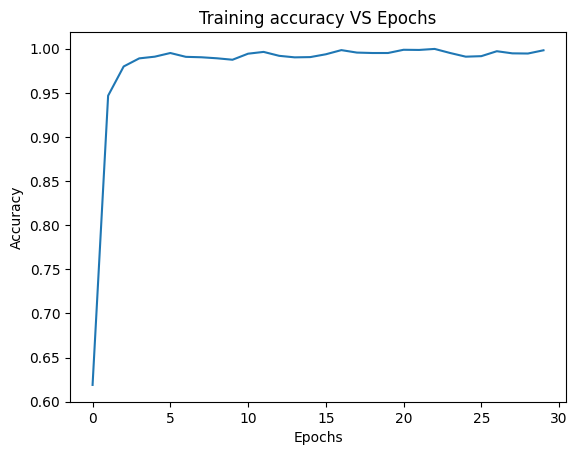

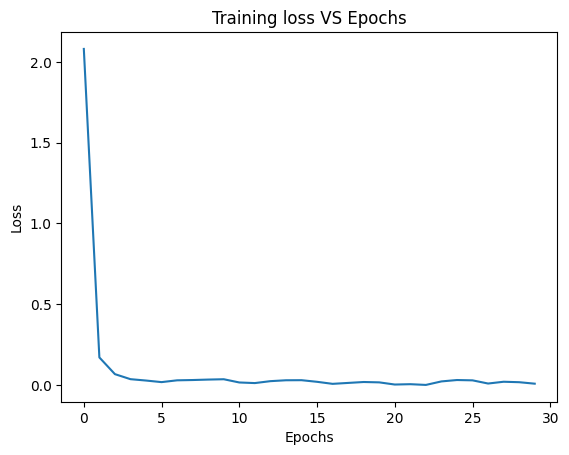

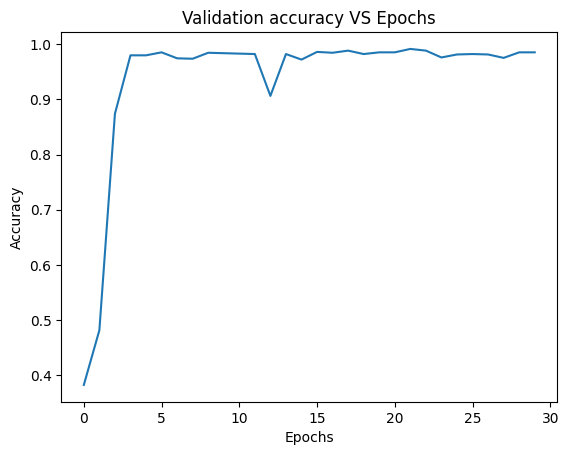

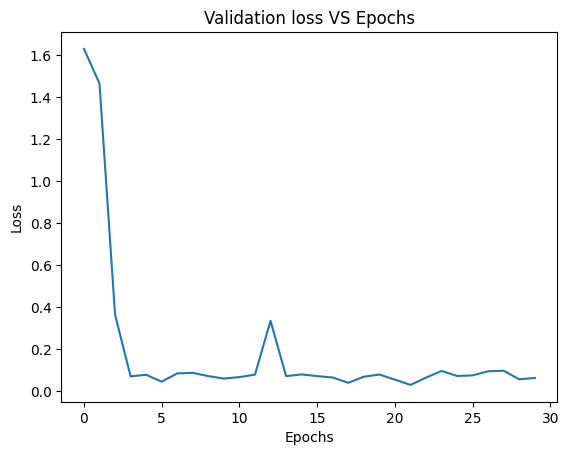

In [ ]:
# Visualizing the VGG model training progress

model_training_visualization(history_VGG)

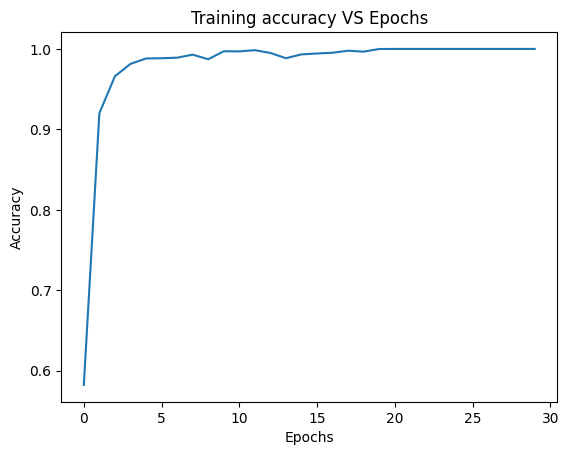

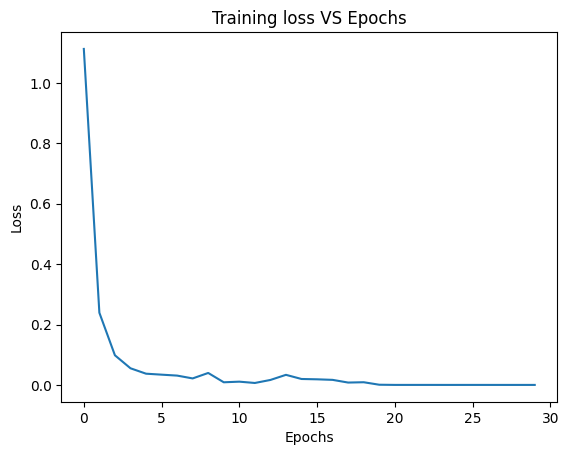

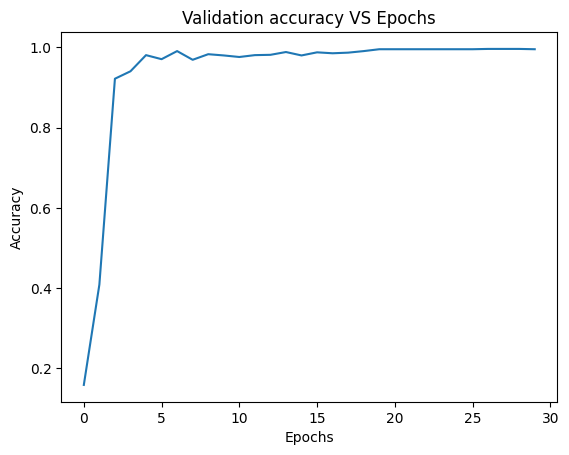

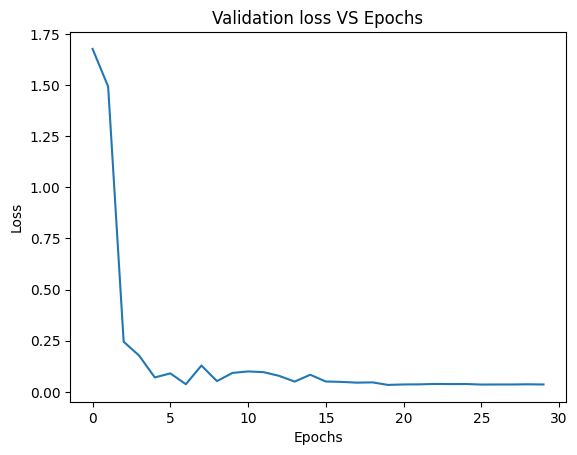

In [ ]:
# Visualizing the Alexnet model training progress

model_training_visualization(history_anet)

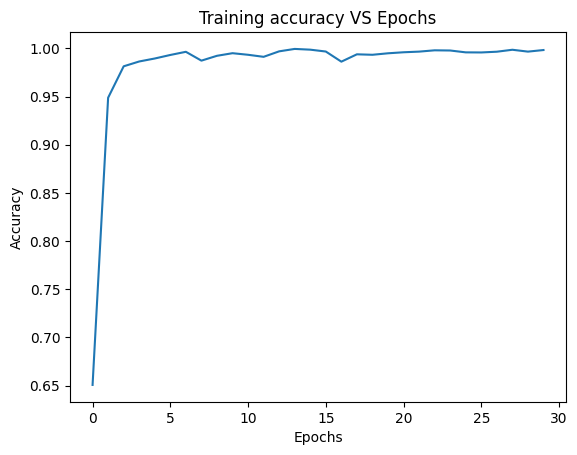

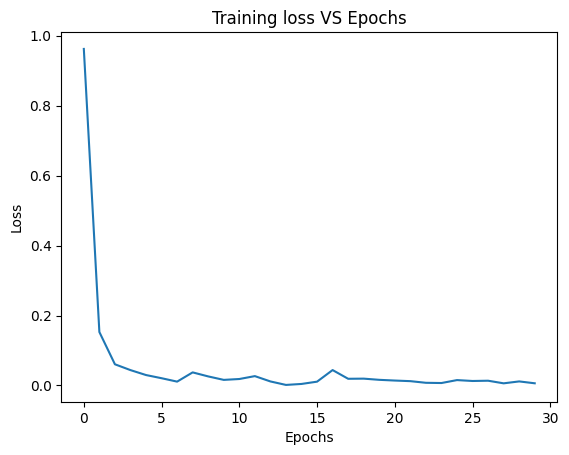

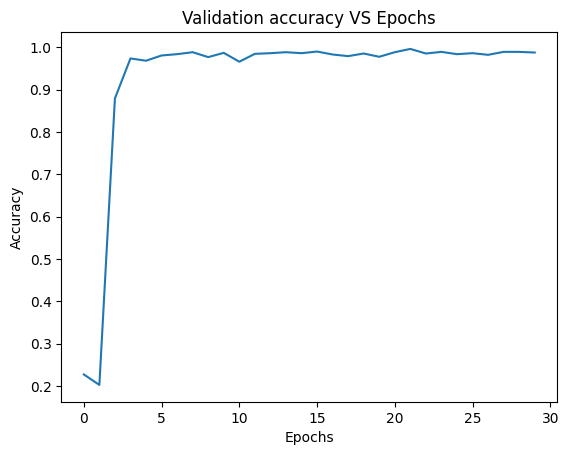

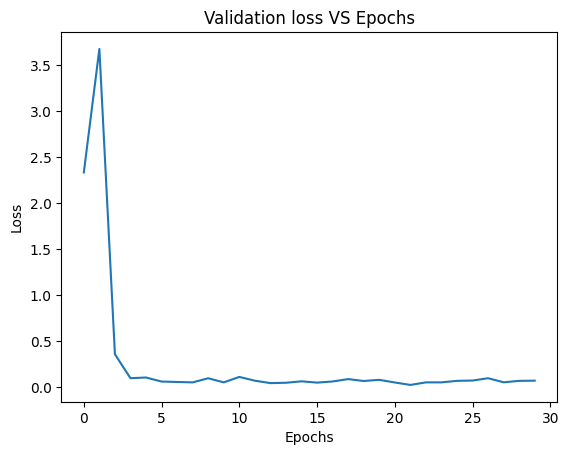

In [ ]:
# Visualizing the ZFnet model training progress

model_training_visualization(history_zfnet)

In [ ]:
# Evaluating the performance of the Alexnet model on the test (unseen) data.

evaluate_model_metrics(model_Anet, test_dataset)

21/21 [==============================] - 9s 430ms/step - loss: 0.0633 - accuracy: 0.9923
Test Loss: 0.0633
Test Accuracy: 99.23%

21/21 [==============================] - 5s 247ms/step

Classification Report:
              precision    recall  f1-score   support

       other       0.99      0.98      0.98       211
        safe       0.99      1.00      1.00       440
        talk       1.00      1.00      1.00       216
        text       1.00      0.99      0.99       220
        turn       0.99      0.99      0.99       205

    accuracy                           0.99      1292
   macro avg       0.99      0.99      0.99      1292
weighted avg       0.99      0.99      0.99      1292



Confusion Matrix:
[[206   3   0   1   1]
 [  0 440   0   0   0]
 [  0   0 215   0   1]
 [  0   1   0 218   1]
 [  2   0   0   0 203]]


In [ ]:
# Evaluating the performance of the ZFnet model on the test (unseen) data.

evaluate_model_metrics(model_zfnet, test_dataset)

21/21 [==============================] - 5s 254ms/step - loss: 0.0864 - accuracy: 0.9868
Test Loss: 0.0864
Test Accuracy: 98.68%

21/21 [==============================] - 6s 292ms/step

Classification Report:
              precision    recall  f1-score   support

       other       0.99      0.96      0.97       211
        safe       0.99      1.00      0.99       440
        talk       0.97      0.99      0.98       216
        text       0.99      0.99      0.99       220
        turn       0.99      0.99      0.99       205

    accuracy                           0.99      1292
   macro avg       0.99      0.98      0.99      1292
weighted avg       0.99      0.99      0.99      1292



Confusion Matrix:
[[202   4   4   1   0]
 [  0 439   0   1   0]
 [  0   0 214   0   2]
 [  1   0   2 217   0]
 [  2   0   0   0 203]]


In [ ]:
# Evaluating the performance of the VGG model on the test (unseen) data.

evaluate_model_metrics(model_VGG, test_dataset)

21/21 [==============================] - 6s 270ms/step - loss: 0.0668 - accuracy: 0.9861
Test Loss: 0.0668
Test Accuracy: 98.61%

21/21 [==============================] - 8s 361ms/step

Classification Report:
              precision    recall  f1-score   support

       other       0.99      0.94      0.96       211
        safe       0.99      1.00      0.99       440
        talk       0.98      0.99      0.99       216
        text       0.99      0.99      0.99       220
        turn       0.98      1.00      0.99       205

    accuracy                           0.99      1292
   macro avg       0.99      0.98      0.98      1292
weighted avg       0.99      0.99      0.99      1292



Confusion Matrix:
[[198   5   4   2   2]
 [  0 440   0   0   0]
 [  1   0 214   1   0]
 [  0   0   0 218   2]
 [  1   0   0   0 204]]


In [24]:
# Plotting few test images for testing our VGG models performance

test_dataset.reset()
pred = model_VGG.predict(test_dataset, verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
true_labels = test_dataset.classes
true_class_indices = test_dataset.labels
class_names = list(test_dataset.class_indices.keys())
random_indices = np.random.choice(len(test_dataset.filenames), size=9, replace=False)
random_images = [cv2.imread(test_dataset.filepaths[i]) for i in random_indices]
random_labels_true = [class_names[true_labels[i]] for i in random_indices]
random_labels_pred = [class_names[predicted_class_indices[i]] for i in random_indices]

plot_images(random_images, random_labels_true, random_labels_pred, class_names)

NameError: name 'test_dataset' is not defined

In [3]:
model_VGG = models.load_model(r"C:\Users\saini\Downloads\modelvgg.h5")

In [18]:
# Defining the dictionary of classes
class_dict = {0: "safe", 1: "talk", 2: "turn", 3: "text", 4: "others"}
# Initializing variables for attentiveness detection
unattentive_frames = 0
total_beeps = 0
attentive_frames=0

# Real time system for predicting the driver behaviour on VGG model
realTimeSystem(class_dict, model_VGG, unattentive_frames = 0, total_beeps = 0, attentive_frames=0)

1/1 [==============================] - 0s 379ms/step
